In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gtsa

from pathlib import Path
import psutil
import xarray as xr
import rasterio
import geopandas as gpd
import pandas as pd
import numpy as np

# Time series computations

Demonstrates memory-efficient per-pixel computations along the time axis.

#### Prerequesites
- Download DEM data with `00_download_dem_data.py` or `00_download_dem_data.ipynb`
- Prepare zarr stack with `01_create_stacks.py` or `01_create_stacks.ipynb`

## Start dask cluster

In [3]:
workers = psutil.cpu_count(logical=True)-1
client = gtsa.io.dask_start_cluster(workers,
                                    ip_addres=None, # replace with address if working on remote machine
                                    port=':8787',
                                   )


Dask dashboard at: http://127.0.0.1:52410/status
Workers: 9
Threads per worker: 1 



## Read zarr stack

In [22]:
data_dir = '../../data/dems/south-cascade/' # small test dataset
# data_dir = '../../data/dems/mount-baker' # large dataset

In [23]:
zarr_fn = Path(data_dir, 'stack/stack.zarr').as_posix()
ds = xr.open_dataset(zarr_fn,chunks='auto',engine='zarr')

In [24]:
ds['band1'] # each is dimensioned along the full time series

<xarray.DataArray 'band1' (time: 11, y: 28392, x: 19282)>
dask.array<open_dataset-band1, shape=(11, 28392, 19282), dtype=float32, chunksize=(11, 1775, 1206), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1970-09-09 1970-09-29 ... 2015-08-27
  * x        (x) float64 5.73e+05 5.73e+05 5.73e+05 ... 5.922e+05 5.922e+05
  * y        (y) float64 5.414e+06 5.414e+06 5.414e+06 ... 5.386e+06 5.386e+06
Attributes:
    AREA_OR_POINT:  Area
    grid_mapping:   spatial_ref

## Example time series computations

### NMAD
Compute per-pixel Normalized Median Absolute Deviation using custom function

In [ ]:
def nmad(array):
    if np.all(np.isnan(array)):
        return np.nan
    else:
        return 1.4826 * np.nanmedian(np.abs(array - np.nanmedian(array)))

In [ ]:
result = xr.apply_ufunc(nmad, 
                        ds,
                        input_core_dims=[['time']],
                        vectorize=True, 
                        dask='parallelized',
                        output_dtypes=[float],
                       )

In [ ]:
array = result.compute()

In [ ]:
nmad_da = subset['band1'].isel(time=0).drop('time') # create empty DataArray container
nmad_da.values = array # replace data values
nmad_da.name   = 'nmad' # give the data variable a name

In [ ]:
nmad_da.plot(vmax=20)

### Linear regression

### Thiel se linear regression

## Assign stack CRS
The `ds.rio.crs` is empty so we must assigned it back to perform spatial operations supported by rioxarray such as subsetting the stack with a polygon geometry. We will retrieve and use the CRS from the reference DEM, to which all DEMs were reprojected during the stacking process outlined in `01_create_stacks.ipynb`.

In [25]:
isinstance(ds.rio.crs, type(None))

True

In [26]:
dems = [x.as_posix() for x in sorted(Path(data_dir).glob('*.tif'))]
date_strings = [x[1:-1] for x in gtsa.io.parse_timestamps(dems,date_string_pattern='_........_')]
date_strings, dems = list(zip(*sorted(zip(date_strings, dems)))) # ensure chronological sorting 
date_times = [pd.to_datetime(x, format="%Y%m%d") for x in date_strings]

ref_dem = dems[-1] # always last after chronological sorting 

src = gtsa.geospatial.rasterio.open(ref_dem)
crs = src.crs

In [27]:
ds = ds.rio.write_crs(crs)

In [28]:
isinstance(ds.rio.crs, type(None))

False

In [29]:
ds.rio.crs

CRS.from_epsg(32610)

## Download RGI glacier polygons
For demonstration purposes, we will use these polygons to subset the zarr stack

In [30]:
rgi_fn = gtsa.dataquery.download_rgi_01_02(output_directory = '../../data/rgi',
                                  region           = '2',
                                  overwrite        = False,
                                  verbose          = True)

rgi_fn = rgi_fn.as_posix()
rgi_fn

/Users/knuth/Documents/sw/gtsa/data/rgi/02_rgi60_WesternCanadaUS.geojson already exists and overwrite option set to False. Skipping download.


'../../data/rgi/02_rgi60_WesternCanadaUS.geojson'

## Select glacier polygon within stack bounds

In [31]:
bounds_df = gtsa.geospatial.bounds2polygon(*ds.rio.bounds(), crs = crs).to_crs('epsg:4326')
gdf = gpd.read_file(rgi_fn, mask= bounds_df.geometry) # supplying a mask is faster
gdf = gdf[gdf['Name'].notna()]
gdf = gdf[gdf['Name'].str.contains('Easton')]

In [32]:
# glacier_gdf.explore() # examine the selected glacier with interactive plot

## Subset the stack with polygon bounds

In [33]:
xmin, ymin, xmax, ymax = gdf.to_crs(crs).bounds.values[0]
subset = ds.sel(x=slice(xmin, xmax), y=slice(ymax,ymin))
# subset = ds.rio.clip_box(minx=xmin,miny=ymin,maxx=xmax,maxy=ymax) # alternative using rioxarray

In [34]:
subset['band1'] # examine subset

<xarray.DataArray 'band1' (time: 11, y: 3902, x: 1778)>
dask.array<getitem, shape=(11, 3902, 1778), dtype=float32, chunksize=(11, 1775, 1056), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 1970-09-09 1970-09-29 ... 2015-08-27
  * x            (x) float64 5.852e+05 5.852e+05 ... 5.869e+05 5.87e+05
  * y            (y) float64 5.402e+06 5.402e+06 ... 5.398e+06 5.398e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    grid_mapping:   spatial_ref

## Determine optimal chunk size
- The optimal in-memory chunk size is a function of data array size and task count
- Reload the data with this chunk size to ensure workers are maximally occupied

In [35]:
tc,yc,xc = gtsa.io.determine_optimal_chuck_size(subset,print_info = True)
ds = xr.open_dataset(zarr_fn,chunks={'time': tc, 'y': yc, 'x':xc},engine='zarr')
ds = ds.rio.write_crs(crs)
subset = ds.sel(x=slice(xmin, xmax), y=slice(ymax,ymin))


Determining optimal chunk size for processing
Chunk shape: (11,230,198)
Chunk size: 2003760 (2.00376 G)


In [36]:
subset['band1'] # examine rechunked subset

<xarray.DataArray 'band1' (time: 11, y: 3902, x: 1778)>
dask.array<getitem, shape=(11, 3902, 1778), dtype=float32, chunksize=(11, 230, 198), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 1970-09-09 1970-09-29 ... 2015-08-27
  * x            (x) float64 5.852e+05 5.852e+05 ... 5.869e+05 5.87e+05
  * y            (y) float64 5.402e+06 5.402e+06 ... 5.398e+06 5.398e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    grid_mapping:   spatial_ref

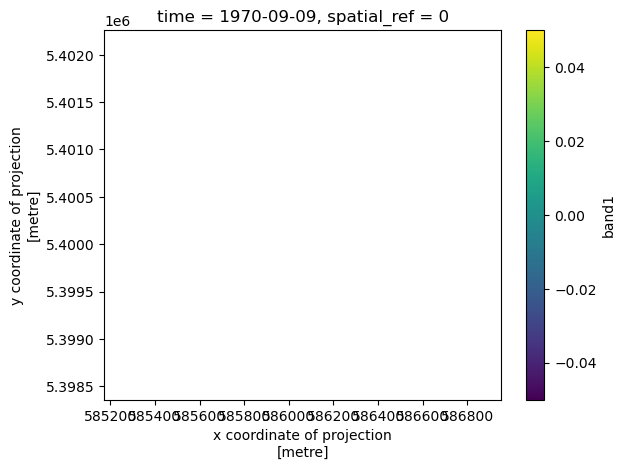

In [40]:
subset['band1'].isel(time=0).plot();  # plot the first DEM

## Time series computations

### Count
Compute per-pixel count using built in method

In [ ]:
# count = ds['band1'].count(axis=0).compute()

In [ ]:
count.plot()

### NMAD
Compute per-pixel Normalized Median Absolute Deviation using custom function

In [42]:
def nmad(array):
    if np.all(np.isnan(array)):
        return np.nan
    else:
        return 1.4826 * np.nanmedian(np.abs(array - np.nanmedian(array)))
    
def apply_nmad(array):
    return np.apply_along_axis(nmad,0,array)

In [54]:
result = xr.apply_ufunc(nmad, 
                        ds,
                        input_core_dims=[['time']],
                        vectorize=True, 
                        dask='parallelized',
                        output_dtypes=[float],
                       )

In [55]:
array = result.compute()

type: [Errno 22] Invalid argument

In [50]:
result = xr.apply_ufunc(apply_nmad,
                        subset['band1'].data,
                        dask="allowed",)

array = result.compute()

In [53]:
array

array([[4.67076914, 5.26836987, 5.55468252, ..., 1.51336685, 0.68754851,
        1.19176282],
       [3.90413174, 3.92838325, 4.10357329, ..., 0.85749009, 0.92608206,
        1.07448684],
       [2.56197334, 2.0132376 , 1.79533594, ..., 0.46584624, 1.01060039,
        0.91667102],
       ...,
       [0.38277576, 0.32268992, 0.2818786 , ..., 0.22315012, 0.20812866,
        0.09374839],
       [0.26559027, 0.14858577, 0.14234191, ..., 0.28251204, 0.107322  ,
        0.11166555],
       [0.17537102, 0.12062413, 0.19482653, ..., 0.45390146, 0.17464709,
        0.14297534]])

In [ ]:
nmad_da = subset['band1'].isel(time=0).drop('time') # create empty DataArray container
nmad_da.values = array # replace data values
nmad_da.name   = 'nmad' # give the data variable a name

In [ ]:
nmad_da.plot(vmax=20)

### Least squares regression

In [154]:
def lsg(x,y):
    mask = np.isfinite(y) # mask np.nan
    return np.polyfit(x[mask], y[mask], 1)[0]


def apply_lsg(x, array):
    return np.apply_along_axis(lsg,0,x,array)

In [160]:
times = [pd.to_datetime(j) for j in subset['band1'].time.values]
decyear_times = [gtsa.utils.date_time_to_decyear(i) for i in times] # need float or int for polyfit
decyear_times = np.array(decyear_times)

In [167]:
result = xr.apply_ufunc(apply_lsg, 
                        decyear_times, 
                        subset,
                        input_core_dims=[['time'], ['time']],
                        vectorize=True, 
                        dask='parallelized',
                        output_dtypes=[float],
                       )

In [169]:
result.compute()

<xarray.Dataset>
Dimensions:      (y: 3032, x: 2345)
Coordinates:
  * x            (x) float64 6.428e+05 6.428e+05 ... 6.451e+05 6.451e+05
  * y            (y) float64 5.359e+06 5.359e+06 ... 5.356e+06 5.356e+06
    spatial_ref  int64 0
Data variables:
    band1        (y, x) float64 -0.002388 -0.004549 ... -0.0488 -0.04741

In [161]:
result = xr.apply_ufunc(lsg, 
                        decyear_times, 
                        subset,
                        input_core_dims=[['time'], ['time']],
                        vectorize=True, 
                        dask='parallelized',
                        output_dtypes=[float],
                       )

In [162]:
result.compute()

<xarray.Dataset>
Dimensions:      (y: 3032, x: 2345)
Coordinates:
  * x            (x) float64 6.428e+05 6.428e+05 ... 6.451e+05 6.451e+05
  * y            (y) float64 5.359e+06 5.359e+06 ... 5.356e+06 5.356e+06
    spatial_ref  int64 0
Data variables:
    band1        (y, x) float64 -0.002388 -0.004549 ... -0.0488 -0.04741

In [158]:
def f(x,y):
    ''' simple least squares fit'''
    mask = np.isfinite(y)
    
    return np.polyfit(x[mask], y[mask], 1)[0]

def g(x,y):
    ''' simple least squares fit'''
    return np.polyfit(x, y, 1)[1]

def get_slope(x, y, dim='time'):
    # x = Pixel value, y = a vector containing the date, dim == dimension
    DS1 = xr.apply_ufunc(
        lsg, x , y,
        input_core_dims=[[dim], [dim]],
        vectorize=True, 
        dask='parallelized',
        output_dtypes=[float],
        )
    return DS1

def get_intercept(x, y, dim='time'):
    DS2 = xr.apply_ufunc(
        g, x , y,
        input_core_dims=[[dim], [dim]],
        vectorize=True, 
        dask='parallelized',
        output_dtypes=[float],
        )
    return DS2

In [159]:
ds1 = get_slope(time_stamps, subset, 'time').compute()

In [122]:
time_stamps = [gtsa.utils.date_time_to_decyear(i) for i in [pd.to_datetime(j) for j in subset['band1'].time.values]]
time_stamps = np.array(time_stamps)

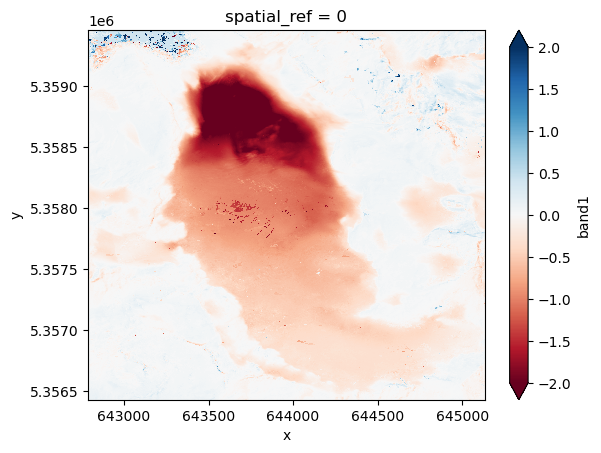

In [132]:
ds1['band1'].plot(vmin =-2,vmax=2, cmap='RdBu')

In [72]:
time_stamps = [gtsa.utils.date_time_to_decyear(i) for i in [pd.to_datetime(j) for j in subset['band1'].time.values]]
time_stamps = np.array(time_stamps)

results = gtsa.temporal.dask_apply_linreg(subset['band1'],
                                          'time', 
                                          kwargs={'times':time_stamps,
                                                  'count_thresh':3})
results = xr.Dataset({'slope':results[0],
                      'intercept':results[1]}).compute()

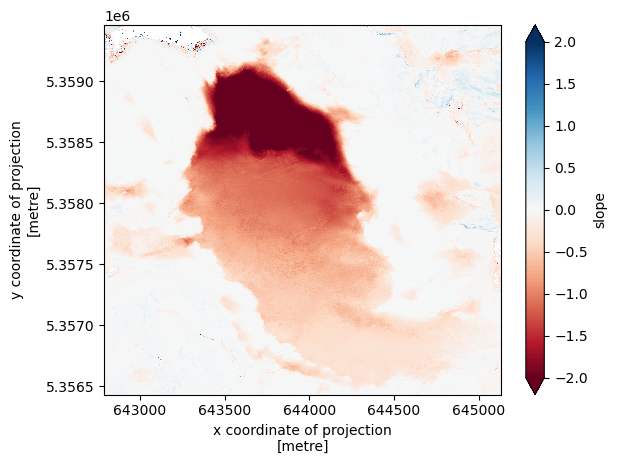

In [153]:
results['slope'].plot(vmin =-2,vmax=2, cmap='RdBu')

In [163]:
! rm -rf example.zarr

In [160]:
subset['band1'].data = subset['band1'].data.rechunk({0:-1, 1:'auto', 2:'auto'}, 
                                                    block_size_limit=1e8, 
                                                    balance=True)

In [162]:
subset.to_zarr?

In [164]:
subset.to_zarr('example.zarr',safe_chunks=False,)

In [ ]:
ds.rio.clip(gdf.to_crs(crs)['geometry'])

In [ ]:
# tc,yc,xc = gtsa.io.determine_optimal_chuck_size(ds,print_info = True)
# ds = xr.open_dataset(zarr_fn,chunks={'time': tc, 'y': yc, 'x':xc},engine='zarr')


In [3]:
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import rasterio
import psutil

# Objective
- Everything should be lazy and parallelized with dask

#### Caution
- If changing code related dask in gtsa library, restart the notebook for changes to take effect, despite the autoreload command above. Lazily loaded states are not reset by the magic command.
- If running code from a python script instead of notebook, start cluster under "\__main__\" e.g. https://github.com/adehecq/ragmac_xdem/blob/master/scripts/main_experiment1.py#L75

In [4]:
workers = psutil.cpu_count(logical=True)-1
client = gtsa.io.dask_start_cluster(workers,
                                    port=':8787')


Dask dashboard at: http://127.0.0.1:8787/status
Workers: 31
Threads per worker: 1 



## Inputs
- Data in the example are stored on AWS S3 in EPSG 4326. 
- The crs metadata is not saved to the zarr files (issue under investigation) so we need to assign it after lazily loading the data.

In [5]:
zarr_url = 'http://petrichor.s3.us-west-2.amazonaws.com/rainier/stack/stack.zarr'
crs = rasterio.crs.CRS.from_epsg(4326)

## Load data
- Rechunk with dask to optimize processing, depending on the data object
- If the total object size is small, use smaller chunks and vice versa

In [6]:
ds = xr.open_dataset(zarr_url,chunks='auto',engine='zarr')
tc,yc,xc = gtsa.io.determine_optimal_chuck_size(ds,print_info = True)
ds = xr.open_dataset(zarr_url,chunks={'time': tc, 'y': yc, 'x':xc},engine='zarr')
ds = ds.rio.write_crs(crs)


Determining optimal chunk size for processing
Chunk shape: (21,120,200)
Chunk size: 2016000 (2.016G)


In [7]:
ds['band1']

<xarray.DataArray 'band1' (time: 21, y: 13133, x: 21786)>
dask.array<open_dataset-5b22096837235a8d20afb30a3df78725band1, shape=(21, 13133, 21786), dtype=float32, chunksize=(21, 120, 200), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 1951-08-16 1955-09-15 ... 2008-10-01
  * x            (x) float64 -121.9 -121.9 -121.9 ... -121.4 -121.4 -121.4
  * y            (y) float64 47.01 47.01 47.01 47.01 ... 46.7 46.7 46.7 46.7
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    grid_mapping:   spatial_ref

## Subset
- Subset stack by the bounds of a glacier, found within the bounds of the DEM stack
- We will choose Nisqually Glacier

In [8]:
rgi02_file = '/mnt/storage/knuth/sites/strato_glaciers/data/rgi/02_rgi60_WesternCanadaUS.geojson'
rgi02_gdf = gpd.read_file(rgi02_file)

In [9]:
xmin, ymin, xmax, ymax = ds['band1'].rio.bounds() # get bounds of stack
bounds_gdf = gtsa.geospatial.bounds2polygon(xmin, xmax, ymin, ymax)

In [10]:
glaciers_gdf = gpd.sjoin(rgi02_gdf, bounds_gdf, predicate='intersects') # intersecting glaciers
glaciers_gdf = glaciers_gdf[glaciers_gdf['Name'].str.len() > 2] # named
glaciers_gdf = glaciers_gdf[glaciers_gdf['Area']>1] # greater than 1 km^2

In [11]:
glaciers_gdf['Name'].values

array(['Carbon Glacier WA', 'Winthrop Glacier WA', 'Russell Glacier WA',
       'North Mowich Glacier WA', 'Emmons Glacier WA',
       'Liberty Gap Glacier WA', 'Edmunds Glacier WA',
       'South Mowich Glacier WA', 'Fryingpan Glacier WA',
       'Tahoma Glacier WA', 'Puyallup Glacier WA', 'Ingraham Glacier WA',
       'Whitman Glacier WA', 'Nisqually Glacier WA', 'Kautz Glacier WA',
       'Ohanapecosh Glacier WA', 'South Tahoma Glacier WA',
       'Cowlitz Glacier WA', 'Wilson Glacier WA'], dtype=object)

In [12]:
glaciers = ['Nisqually Glacier WA', ]
glacier_gdf = glaciers_gdf[glaciers_gdf['Name'].str.contains(glaciers[0])]

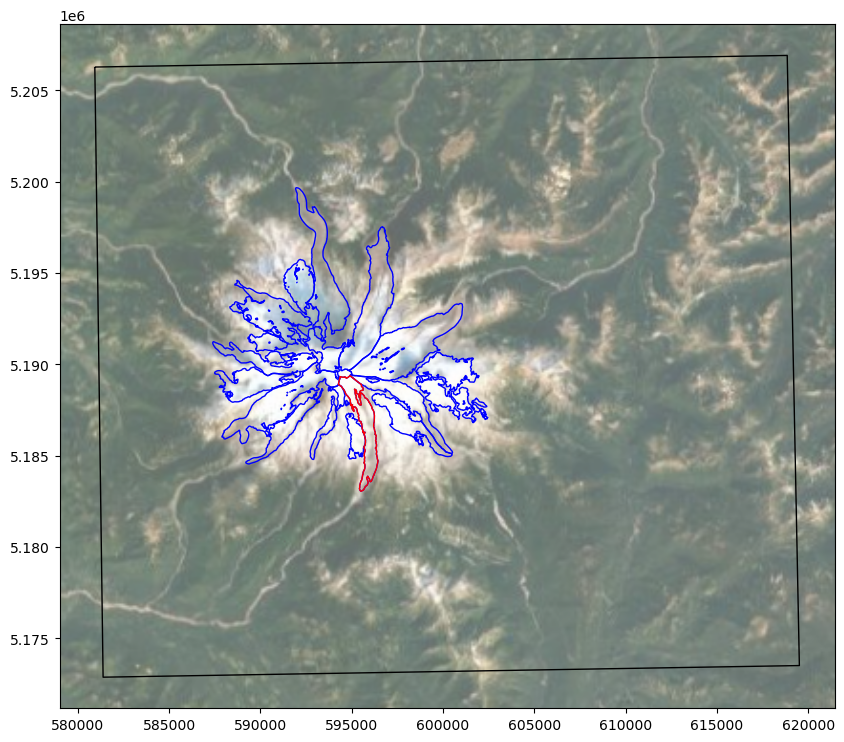

In [13]:
fig,ax = plt.subplots(1,figsize=(10,10))
bounds_gdf.to_crs(ds.rio.estimate_utm_crs()).plot(ax = ax, facecolor = 'none', edgecolor='k')
glaciers_gdf.to_crs(ds.rio.estimate_utm_crs()).plot(ax=ax, facecolor = 'none', edgecolor='b')
glacier_gdf.to_crs(ds.rio.estimate_utm_crs()).plot(ax=ax, facecolor = 'none', edgecolor='r')
ctx.add_basemap(ax, 
                source="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
                crs= ds.rio.estimate_utm_crs(),
                alpha = 0.6,
                zoom=10)

In [14]:
#optional small window for testing
xmin, xmax = -121.79, -121.78
ymin, ymax = 46.89, 46.90

# xmin, ymin, xmax, ymax = glacier_gdf.bounds.values[0]
subset = ds.sel(x=slice(xmin, xmax), y=slice(ymax,ymin))

## Plot a DEM

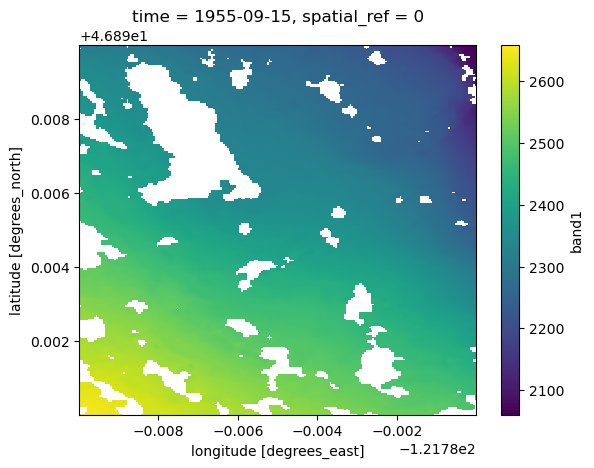

In [15]:
subset['band1'].isel(time=1).plot();

## Compute per pixel DEM count

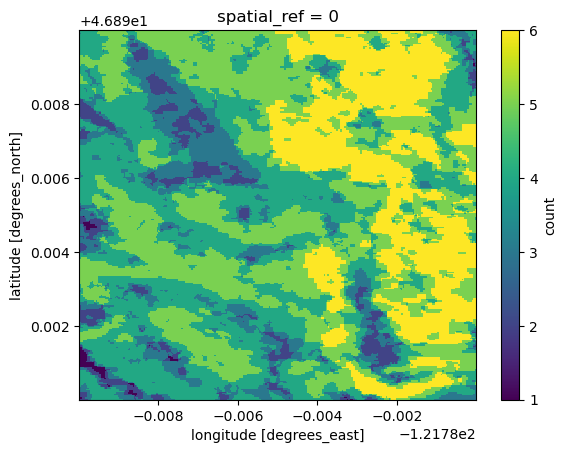

In [16]:
count_da = gtsa.temporal.xr_dask_count(subset)
count_da.plot();

## Compute per pixel DEM nmad

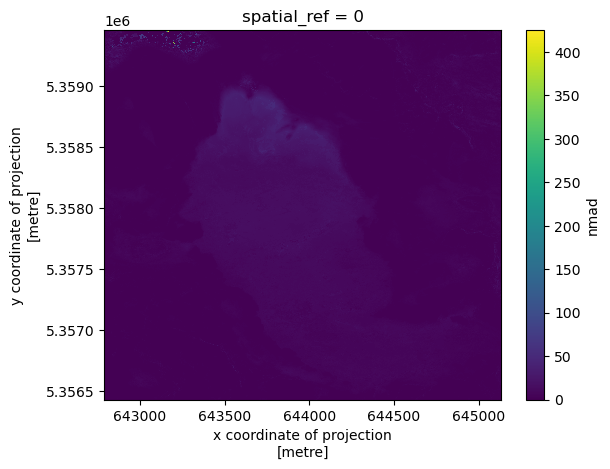

In [78]:
nmad_da = gtsa.temporal.xr_dask_nmad(subset)
nmad_da.plot();

## Linear regression

In [18]:
time_stamps = [gtsa.utils.date_time_to_decyear(i) for i in [pd.to_datetime(j) for j in subset['band1'].time.values]]
time_stamps = np.array(time_stamps)

results = gtsa.temporal.dask_apply_linreg(subset['band1'],
                                          'time', 
                                          kwargs={'times':time_stamps,
                                                  'count_thresh':3})
results = xr.Dataset({'slope':results[0],
                      'intercept':results[1]}).compute()

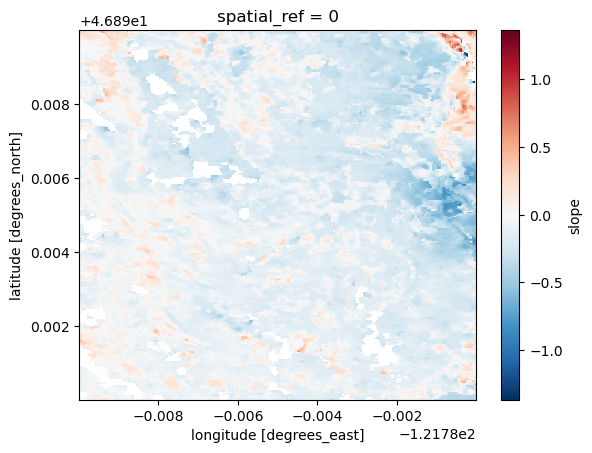

In [19]:
results['slope'].plot()

## Gaussian Process regression

In [20]:
kernel = gtsa.temporal.GPR_glacier_kernel()

In [21]:
time_stamps = [gtsa.utils.date_time_to_decyear(i) for i in [pd.to_datetime(j) for j in subset['band1'].time.values]]
time_stamps = np.array(time_stamps)

In [22]:
prediction_time_series = gtsa.temporal.create_prediction_timeseries(start_date = '1950-01-01',
                                               end_date = '2020-01-01',
                                               dt ='M')

In [23]:
ds_result = gtsa.temporal.dask_apply_GPR(subset['band1'],
                                       'time', 
                                       kwargs={'times':time_stamps,
                                               'kernel': kernel,
                                               'prediction_time_series' : prediction_time_series})

In [24]:
ds_result['mean_prediction']

<xarray.DataArray 'mean_prediction' (time: 840, y: 436, x: 436)>
dask.array<rechunk-merge, shape=(840, 436, 436), dtype=float64, chunksize=(752, 109, 146), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 -121.8 -121.8 -121.8 ... -121.8 -121.8 -121.8
  * y            (y) float64 46.9 46.9 46.9 46.9 ... 46.89 46.89 46.89 46.89
    spatial_ref  int64 0
  * time         (time) float64 1.95e+03 1.95e+03 1.95e+03 ... 2.02e+03 2.02e+03

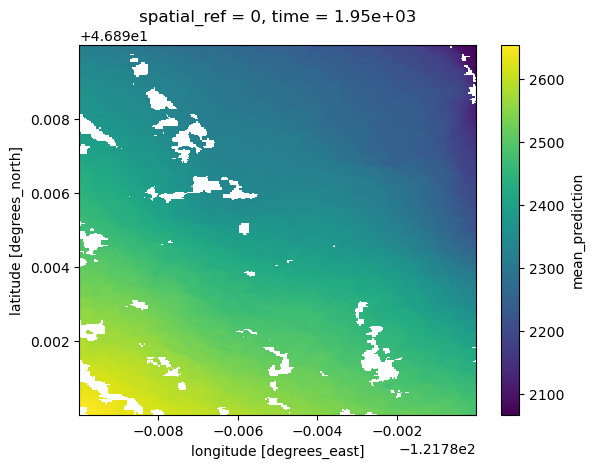

In [25]:
ds_result['mean_prediction'].isel(time=1).plot();

In [26]:
! rm -rf test.zarr

In [27]:
ds_result.to_zarr('test.zarr')

In [28]:
r = xr.open_dataset('test.zarr', engine = 'zarr')

In [29]:
r

<xarray.Dataset>
Dimensions:          (time: 840, y: 436, x: 436)
Coordinates:
    spatial_ref      int64 ...
  * time             (time) float64 1.95e+03 1.95e+03 ... 2.02e+03 2.02e+03
  * x                (x) float64 -121.8 -121.8 -121.8 ... -121.8 -121.8 -121.8
  * y                (y) float64 46.9 46.9 46.9 46.9 ... 46.89 46.89 46.89 46.89
Data variables:
    mean_prediction  (time, y, x) float64 ...
    std_prediction   (time, y, x) float64 ...

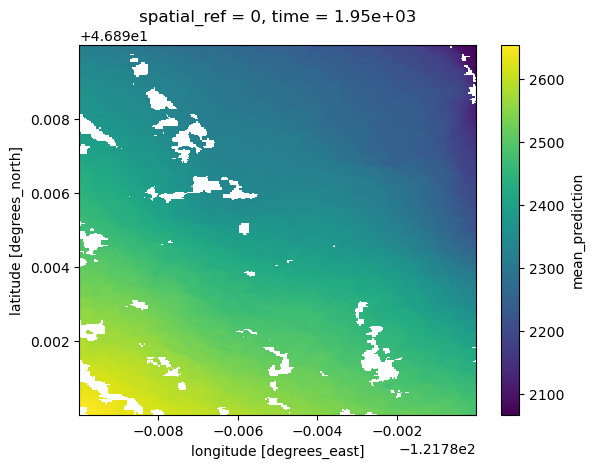

In [30]:
r['mean_prediction'].isel(time=1).plot()

In [171]:
subset['x'].values[0] + 100

642888.5

In [185]:
offset = 7

p = (ds['x'].values[0], ds['y'].values[0])
xmin = p[0] - offset
xmax = p[0] + offset
ymin = p[1] - offset
ymax = p[1] + offset

sub = ds.sel(x=slice(xmin, xmax), y=slice(ymax,ymin))

In [186]:
sub['band1'].values[0]

array([[nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan]], dtype=float32)

In [177]:
offset = 0
subset['band1'].sel(x    = subset['x'].values[0] + offset, 
                    y    = subset['y'].values[0] - offset, 
                    time = subset['time'].values[0]).values

array(1599.9955, dtype=float32)

In [178]:
offset = 100
subset['band1'].sel(x    = subset['x'].values[0] + offset, 
                    y    = subset['y'].values[0] - offset, 
                    time = subset['time'].values[0]).values

array(1621.017, dtype=float32)

2023-07-12 14:38:30,299 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 3 memory: 829 MB fds: 45>>
Traceback (most recent call last):
  File "/Users/knuth/Documents/sw/miniconda3/envs/gtsa/lib/python3.11/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/Users/knuth/Documents/sw/miniconda3/envs/gtsa/lib/python3.11/site-packages/distributed/system_monitor.py", line 160, in update
    net_ioc = psutil.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/knuth/Documents/sw/miniconda3/envs/gtsa/lib/python3.11/site-packages/psutil/__init__.py", line 2119, in net_io_counters
    rawdict = _psplatform.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 12] Cannot allocate memory


## GP on single array
- use this to test different kernels

In [31]:
arr = subset['band1'].isel(x=1, y = 1).values

In [32]:
mean_prediction, std_prediction = gtsa.temporal.dask_GPR(arr,
                                                         times = time_stamps,
                                                         kernel = kernel,
                                                         prediction_time_series = prediction_time_series)

In [33]:
GPR_df = pd.DataFrame([mean_prediction,]).T
GPR_df.index = prediction_time_series

GPR_std_df = pd.DataFrame([std_prediction,]).T
GPR_std_df.index = prediction_time_series

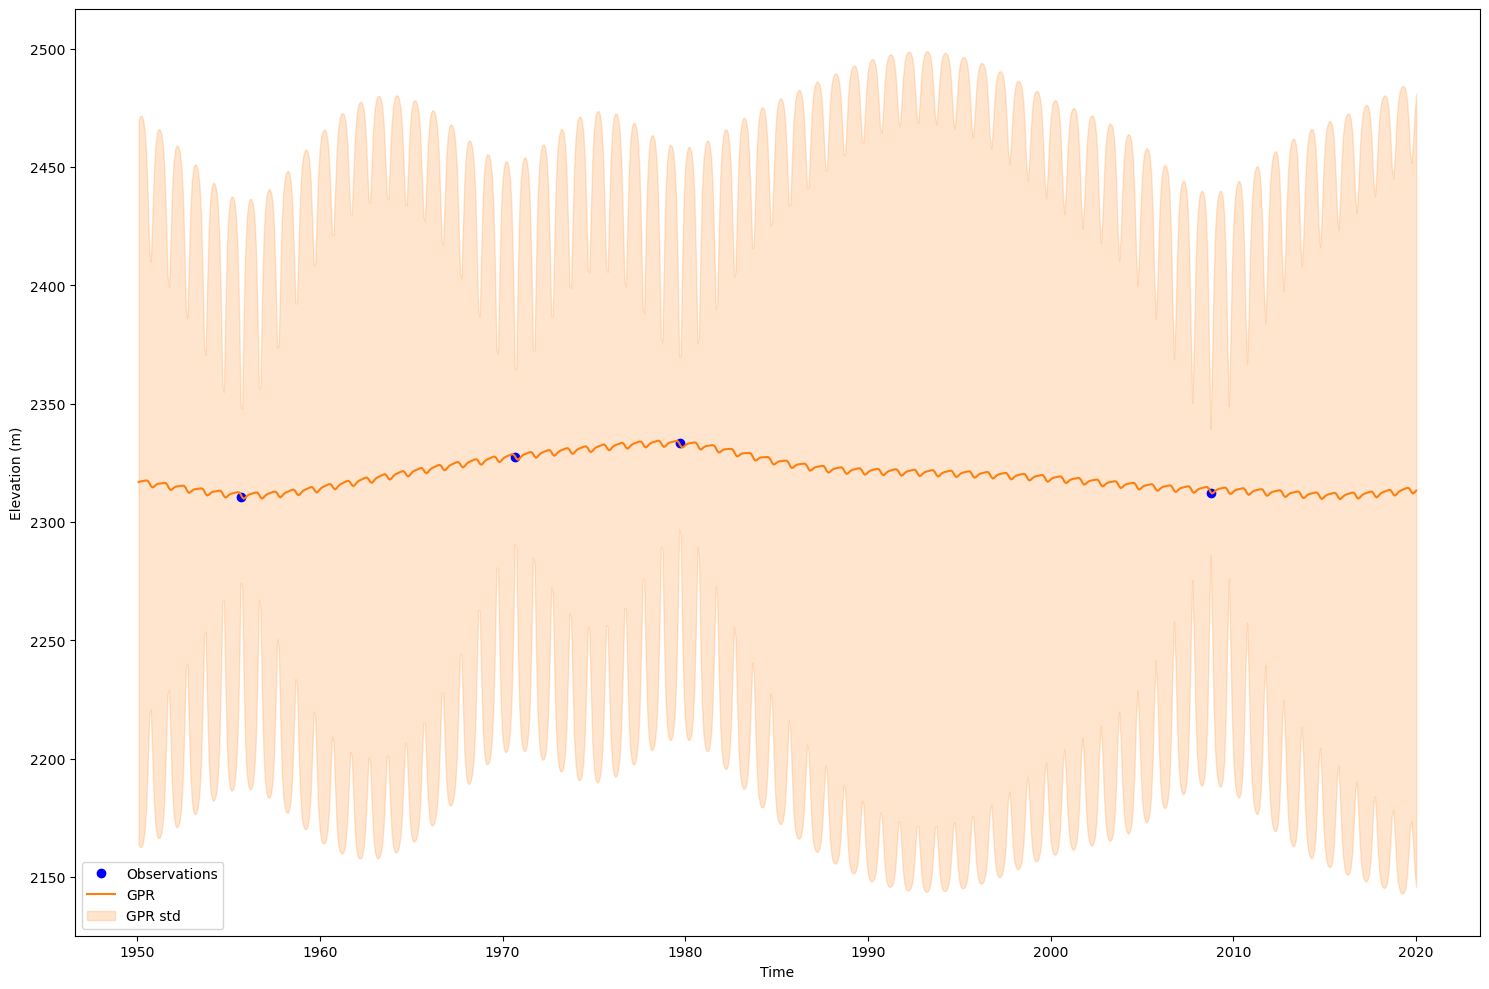

In [34]:
gtsa.plotting.plot_time_series_gallery(np.array([time_stamps,]),
                                       np.array([arr,]),
                                       predictions_df_list=[GPR_df],
                                       std_df_list=[GPR_std_df],
                                       legend_labels = ["Observations",
                                                           "GPR",
                                                           "GPR std"])